In [49]:
import json
import re
from dotenv import load_dotenv
from pathlib import Path
from typing import List, Dict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tinker
from tinker import types
from tinker_cookbook.tokenizer_utils import get_tokenizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import time
from concurrent.futures import Future
import torch
from tinker.types.tensor_data import TensorData
from sentence_transformers import SentenceTransformer
import random


In [25]:
BASE_MODEL = "meta-llama/Llama-3.1-8B-Instruct"
LOG_DIR = Path("logs/reverse_rl_sft_run")
LOG_DIR.mkdir(parents=True, exist_ok=True)
FINETUNE_PATH = "data/finetune_reverse_rl.jsonl"
LABELS = ["A", "B", "C", "D"]
load_dotenv()
SEED = 42

In [ ]:
def load_eval_examples(path: str) -> List[Dict]:
    """
    Load reverse RL evaluation examples from a JSONL file.

    Each line should have:
      - "prompt": the full text prompt to feed the model
      - "target": the reference meaning/definition text
    """
    examples: List[Dict] = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            ex = json.loads(line)
            # Expect keys: "prompt", "target"
            examples.append(ex)
    return examples


def example_to_prompt(ex: Dict) -> str:
    """
    For RL evaluation, the prompt is already fully constructed.
    """
    return ex["prompt"]


def example_to_target(ex: Dict) -> str:
    """
    Gold/reference meaning text for computing similarity/reward.
    """
    return ex["target"]


In [6]:
def parse_explanation(output_text: str) -> str:
    """
    For the reverse RL explanation task, we keep the full generated text,
    trimmed, so it can be compared against the reference meaning.
    """
    return output_text.strip()


In [7]:
# simple token-level F1 as a similarity metric
_token_re = re.compile(r"\w+")

def _tokenize(text: str):
    return _token_re.findall(text.lower())

def explanation_f1(pred: str, target: str) -> float:
    """
    Simple token-level F1 between prediction and target.
    """
    pred_tokens = _tokenize(pred)
    tgt_tokens  = _tokenize(target)

    if not pred_tokens or not tgt_tokens:
        return 0.0

    pred_counts = {}
    tgt_counts = {}
    for t in pred_tokens:
        pred_counts[t] = pred_counts.get(t, 0) + 1
    for t in tgt_tokens:
        tgt_counts[t] = tgt_counts.get(t, 0) + 1

    overlap = 0
    for t, c in pred_counts.items():
        if t in tgt_counts:
            overlap += min(c, tgt_counts[t])

    precision = overlap / max(len(pred_tokens), 1)
    recall    = overlap / max(len(tgt_tokens), 1)
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)


def evaluate_reverse_rl(
    sampling_client: tinker.SamplingClient,
    model_name: str,
    jsonl_path: str,
    max_examples: int | None = None,
):
    """
    Evaluate a model on the reverse explanation task.

    - Reads eval_reverse_rl.jsonl (prompt + target).
    - Generates an explanation for each prompt.
    - Computes a token-level F1 between generation and target.
    """
    examples = load_eval_examples(jsonl_path)
    if max_examples is not None:
        examples = examples[:max_examples]

    tokenizer = get_tokenizer(model_name)
    sampling_params = types.SamplingParams(
        max_tokens=64,      # allow short explanation
        temperature=0.0,    # deterministic for eval
        top_p=1.0,
        stop=["\n"],        # stop at newline
    )

    scores: List[float] = []
    preds: List[str] = []
    targets: List[str] = []

    for ex in examples:
        prompt_text = example_to_prompt(ex)
        target_text = example_to_target(ex)

        tokens = tokenizer.encode(prompt_text, add_special_tokens=True)
        model_input = types.ModelInput.from_ints(tokens=tokens)

        result = sampling_client.sample(
            prompt=model_input,
            sampling_params=sampling_params,
            num_samples=1,
        ).result()

        gen_tokens = result.sequences[0].tokens
        gen_text   = tokenizer.decode(gen_tokens)
        pred_text  = parse_explanation(gen_text)

        f1 = explanation_f1(pred_text, target_text)

        scores.append(f1)
        preds.append(pred_text)
        targets.append(target_text)

    mean_f1 = float(np.mean(scores)) if scores else 0.0

    return {
        "mean_f1": mean_f1,
        "scores": scores,
        "preds": preds,
        "targets": targets,
    }

In [9]:
def eval_finetuned_rl(jsonl_path: str, model_path: str) -> None:
    """
    Evaluate a FINETUNED model (e.g., SFT or RL-tuned) on the reverse
    explanation task using eval_reverse_rl.jsonl.

    model_path: the Tinker sampler weights URI/path returned by training.
    """
    service_client = tinker.ServiceClient()
    sampling_client = service_client.create_sampling_client(model_path=model_path)

    metrics = evaluate_reverse_rl(
        sampling_client=sampling_client,
        model_name=BASE_MODEL,  # tokenizer based on base model name
        jsonl_path=jsonl_path,
    )

    print("=== FINETUNED REVERSE RL RESULTS ===")
    print(f"Mean token-F1 vs target meaning: {metrics['mean_f1']:.4f}")

    out_path = Path("finetuned_reverse_rl_metrics.json")
    out_path.write_text(json.dumps(metrics, indent=2, ensure_ascii=False))
    print(f"\nSaved finetuned reverse RL metrics to {out_path}")

In [8]:
def eval_baseline_rl(jsonl_path: str) -> None:
    """
    Evaluate the BASE model on the reverse explanation task
    using eval_reverse_rl.jsonl.
    """
    service_client = tinker.ServiceClient()
    sampling_client = service_client.create_sampling_client(base_model=BASE_MODEL)

    metrics = evaluate_reverse_rl(
        sampling_client=sampling_client,
        model_name=BASE_MODEL,
        jsonl_path=jsonl_path,
    )

    print("=== BASELINE REVERSE RL RESULTS ===")
    print(f"Mean token-F1 vs target meaning: {metrics['mean_f1']:.4f}")

    out_path = Path("baseline_reverse_rl_metrics.json")
    out_path.write_text(json.dumps(metrics, indent=2, ensure_ascii=False))
    print(f"\nSaved baseline reverse RL metrics to {out_path}")

In [10]:
def load_finetune_examples(path: str):
    """
    Load reverse finetuning (or RL pretraining) examples from a JSONL file.

    Each line should have:
      - "prompt": the input text
      - "completion": the target explanation text
    """
    examples = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            ex = json.loads(line)
            examples.append(ex)
    return examples


In [11]:
def make_datums(examples, tokenizer) -> List[types.Datum]:
    """
    Turn (prompt, completion_text) into Tinker Datums.

    We feed the full prompt + completion, but only
    put loss on the completion token(s).
    """
    datums: List[types.Datum] = []

    for ex in examples:
        prompt_text = ex["prompt"]
        completion_text = ex["completion"]  # explanation text for reverse RL SFT

        # Encode prompt with specials
        prompt_tokens = tokenizer.encode(prompt_text, add_special_tokens=True)
        prompt_weights = [0] * len(prompt_tokens)

        # Encode completion (no specials)
        # Add a leading space so the completion starts on a fresh token boundary.
        completion_tokens = tokenizer.encode(" " + completion_text, add_special_tokens=False)
        completion_weights = [1] * len(completion_tokens)

        tokens = prompt_tokens + completion_tokens
        weights = prompt_weights + completion_weights

        # Standard LM shifting: predict each token from previous.
        input_tokens = tokens[:-1]
        target_tokens = tokens[1:]
        target_weights = weights[1:]

        datum = types.Datum(
            model_input=types.ModelInput.from_ints(tokens=input_tokens),
            loss_fn_inputs=dict(
                target_tokens=target_tokens,
                weights=target_weights,
            ),
        )
        datums.append(datum)

    return datums


In [15]:
def batch_iter(datums: List[types.Datum], batch_size: int):
    n = len(datums)
    idxs = np.arange(n)
    np.random.shuffle(idxs)
    for i in range(0, n, batch_size):
        batch_idx = idxs[i : i + batch_size]
        yield [datums[j] for j in batch_idx]

In [12]:
eval_baseline_rl("data/eval_reverse_rl.jsonl")

=== BASELINE REVERSE RL RESULTS ===
Mean token-F1 vs target meaning: 0.0698

Saved baseline reverse RL metrics to baseline_reverse_rl_metrics.json


In [26]:
# Supervised fine-tuning (SFT) for the reverse explanation task
# using finetune_reverse_rl.jsonl

service_client = tinker.ServiceClient()
training_client = service_client.create_lora_training_client(base_model=BASE_MODEL)
tokenizer = training_client.get_tokenizer()

# FINETUNE_PATH should point to your reverse RL SFT data:
# e.g. FINETUNE_PATH = "/mnt/data/finetune_reverse_rl.jsonl"
examples = load_finetune_examples(FINETUNE_PATH)
datums = make_datums(examples, tokenizer)

metrics_path = LOG_DIR / "metrics.jsonl"

num_epochs = 5
batch_size = 16
learning_rate = 1e-4
global_step = 0

for epoch in range(1, num_epochs + 1):
    print(f"=== Epoch {epoch}/{num_epochs} ===")

    for batch in batch_iter(datums, batch_size=batch_size):
        global_step += 1

        fwdbwd_fut = training_client.forward_backward(batch, "cross_entropy")
        optim_fut = training_client.optim_step(
            types.AdamParams(
                learning_rate=learning_rate,
                beta1=0.89,
                beta2=0.99,
                eps=1e-8,
            )
        )

        fwdbwd_res = fwdbwd_fut.result()
        optim_fut.result()

        # Built-in loss metric
        loss_sum = fwdbwd_res.metrics["loss:sum"]

        # Compute total number of *weighted* tokens for a mean NLL
        total_tokens = 0
        for d in batch:
            w = d.loss_fn_inputs["weights"]  # list or TensorData
            if hasattr(w, "data"):           # handle TensorData just in case
                w_np = np.array(w.data)
            else:
                w_np = np.array(w)
            total_tokens += (w_np > 0).sum()

        mean_nll = float(loss_sum / (total_tokens + 1e-8))

        record = {
            "step": global_step,
            "epoch": epoch,
            "train_loss_sum": float(loss_sum),
            "train_mean_nll": mean_nll,
        }
        with metrics_path.open("a", encoding="utf-8") as f:
            f.write(json.dumps(record) + "\n")

        if global_step % 5 == 0:
            print(
                f"step {global_step} | "
                f"train_loss_sum={loss_sum:.4f} | "
                f"train_mean_nll={mean_nll:.4f}"
            )

# 1) Sampler weights – for evaluation
resp_sampler = await training_client.save_weights_for_sampler(name="reverse_rl_sft")
print("Saved SFT sampler weights at:", resp_sampler.path)

# 2) Full training state – for RL initialization
resp_state = await training_client.save_state(name="reverse_rl_sft_state")
print("Saved full SFT training state at:", resp_state.path)

=== Epoch 1/5 ===
step 5 | train_loss_sum=313.6976 | train_mean_nll=1.8897
step 10 | train_loss_sum=410.6472 | train_mean_nll=1.9743
step 15 | train_loss_sum=242.4042 | train_mean_nll=1.6379
step 20 | train_loss_sum=228.6958 | train_mean_nll=1.7067
step 25 | train_loss_sum=221.1630 | train_mean_nll=1.2711
step 30 | train_loss_sum=268.6232 | train_mean_nll=1.5007
step 35 | train_loss_sum=38.8387 | train_mean_nll=1.1769
=== Epoch 2/5 ===
step 40 | train_loss_sum=124.3659 | train_mean_nll=0.7921
step 45 | train_loss_sum=168.3746 | train_mean_nll=0.9151
step 50 | train_loss_sum=132.4776 | train_mean_nll=0.7360
step 55 | train_loss_sum=90.7714 | train_mean_nll=0.4880
step 60 | train_loss_sum=88.5885 | train_mean_nll=0.4789
step 65 | train_loss_sum=86.0011 | train_mean_nll=0.4456
step 70 | train_loss_sum=0.4327 | train_mean_nll=0.0206
=== Epoch 3/5 ===
step 75 | train_loss_sum=43.1256 | train_mean_nll=0.2630
step 80 | train_loss_sum=10.3443 | train_mean_nll=0.0598
step 85 | train_loss_sum=31

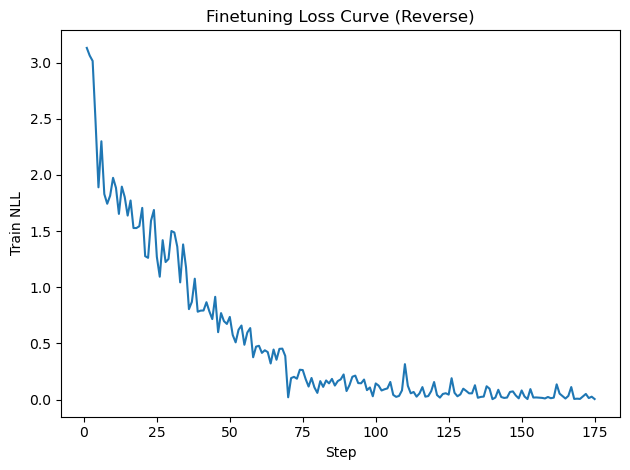

In [29]:
metrics_path = "logs/reverse_rl_sft_run/metrics.jsonl"
df = pd.read_json(metrics_path, lines=True)

plt.figure()
plt.plot(df["step"], df["train_mean_nll"])
plt.xlabel("Step")
plt.ylabel("Train NLL")
plt.title("Finetuning Loss Curve (Reverse)")
plt.tight_layout()
plt.show()

In [ ]:
eval_finetuned_rl(
    "data/eval_reverse_rl.jsonl",
    "tinker://e91e23ef-0595-5360-b4fa-b61a2231288c:train:0/sampler_weights/reverse_rl_sft"  # paste the path from training
)

=== FINETUNED REVERSE RL RESULTS ===
Mean token-F1 vs target meaning: 0.2187

Saved finetuned reverse RL metrics to finetuned_reverse_rl_metrics.json


In [21]:
def compute_reward(pred: str, target: str) -> float:
    """
    Turn explanation quality into a scalar reward.
    You can tweak scaling or add penalties here.
    """
    base_score = explanation_f1(pred, target)  # in [0, 1]
    return float(base_score)


In [30]:
# -------------- RL hyperparams (tweak as needed) --------------
BATCH_SIZE   = 64      # prompts per batch
GROUP_SIZE   = 4       # samples per prompt (GRPO-style groups)
LEARNING_RATE = 4e-5   # similar to Tinker rl_loop default :contentReference[oaicite:1]{index=1}
MAX_TOKENS   = 64      # max tokens for explanation
N_EPOCHS     = 2       # start small; this is online RL
SAVE_EVERY   = 50      # save sampler weights every N steps (optional)


# -------------- Load RL training examples --------------
# Re-use your existing loader: {"prompt": ..., "completion": ...}
rl_examples = load_finetune_examples(FINETUNE_PATH)
n_examples  = len(rl_examples)
n_batches   = n_examples // BATCH_SIZE
print(f"Loaded {n_examples} RL examples => {n_batches} batches of {BATCH_SIZE}.")


# -------------- Create training client starting from SFT --------------
service_client = tinker.ServiceClient()
training_client = service_client.create_training_client_from_state(resp_state.path)

tokenizer = training_client.get_tokenizer()

sampling_params = types.SamplingParams(
    max_tokens=MAX_TOKENS,
    temperature=0.7,
    top_p=0.9,
    stop=["\n"],
)

adam_params = types.AdamParams(
    learning_rate=LEARNING_RATE,
    beta1=0.9,
    beta2=0.95,
    eps=1e-8,
)

LOG_DIR = Path("logs/reverse_rl_grpo_run")
LOG_DIR.mkdir(parents=True, exist_ok=True)
metrics_path = LOG_DIR / "metrics.jsonl"

global_step = 0

for epoch in range(1, N_EPOCHS + 1):
    print(f"\n=== RL Epoch {epoch}/{N_EPOCHS} ===")

    # Shuffle examples each epoch
    idxs = np.arange(n_examples)
    np.random.shuffle(idxs)

    # Iterate over *all* examples, including the last partial batch
    for start in range(0, n_examples, BATCH_SIZE):
        t_start = time.time()
        global_step += 1

        end = min(start + BATCH_SIZE, n_examples)
        batch_idxs = idxs[start:end]
        batch_examples = [rl_examples[i] for i in batch_idxs]

        # We'll collect rollouts here
        batch_futures: List[List[Future[types.SampleResponse]]] = []
        batch_prompt_tokens: List[List[int]] = []
        batch_targets: List[str] = []

        # --------- 2) Create a sampler from current training weights ---------
        sampling_path = training_client.save_weights_for_sampler(
            name=f"rl_step_{global_step:06d}"
        ).result().path
        sampling_client = service_client.create_sampling_client(model_path=sampling_path)

        # --------- 3) Launch sampling (GROUP_SIZE per prompt) ---------
        for ex in batch_examples:
            prompt_text  = ex["prompt"]
            target_text  = ex["completion"]  # gold meaning for reward

            prompt_tokens = tokenizer.encode(prompt_text, add_special_tokens=True)
            model_input   = types.ModelInput.from_ints(tokens=prompt_tokens)

            sample_futures: List[Future[types.SampleResponse]] = []
            for _ in range(GROUP_SIZE):
                fut = sampling_client.sample(
                    prompt=model_input,
                    num_samples=1,
                    sampling_params=sampling_params,
                )
                sample_futures.append(fut)

            batch_futures.append(sample_futures)
            batch_prompt_tokens.append(prompt_tokens)
            batch_targets.append(target_text)

        # --------- 4) Gather samples, compute rewards, advantages ---------
        training_datums: List[types.Datum] = []
        batch_rewards: List[float] = []

        for sample_futures, prompt_tokens, target_text in zip(
            batch_futures, batch_prompt_tokens, batch_targets
        ):
            group_rewards: List[float] = []
            group_tokens: List[List[int]] = []
            group_logprobs: List[List[float]] = []
            group_ob_lens: List[int] = []

            for fut in sample_futures:
                sample_result = fut.result()
                seq = sample_result.sequences[0]
                sampled_tokens = seq.tokens
                sampled_logprobs = seq.logprobs
                assert sampled_logprobs is not None

                all_tokens = prompt_tokens + sampled_tokens

                # Observation length: all prompt tokens except the very first BOS
                ob_len = len(prompt_tokens) - 1

                # Decode only generated tokens for reward
                gen_text = tokenizer.decode(sampled_tokens)
                pred_text = parse_explanation(gen_text)

                reward = compute_reward(pred_text, target_text)

                group_tokens.append(all_tokens)
                group_logprobs.append(sampled_logprobs)
                group_ob_lens.append(ob_len)
                group_rewards.append(reward)

            # Group-relative baseline (GRPO-style)
            if len(group_rewards) == 0:
                continue

            group_mean = float(sum(group_rewards) / len(group_rewards))
            advantages = [r - group_mean for r in group_rewards]

            batch_rewards.append(group_mean)

            # If all advantages are 0, skip (no learning signal)
            if all(a == 0.0 for a in advantages):
                continue

            # --------- 5) Convert each sample in the group to a Datum ---------
            for tokens, logprob, advantage, ob_len in zip(
                group_tokens, group_logprobs, advantages, group_ob_lens
            ):
                # Standard LM shift
                input_tokens  = tokens[:-1]
                target_tokens = tokens[1:]

                # Sampling logprobs over whole prefix; 0s for prompt region,
                # then actual logprobs for generated region.
                all_logprobs = [0.0] * ob_len + list(logprob)
                if len(all_logprobs) < len(input_tokens):
                    all_logprobs += [0.0] * (len(input_tokens) - len(all_logprobs))
                all_logprobs = all_logprobs[: len(input_tokens)]

                # Advantages: 0 in prompt region, then constant advantage for generated region
                all_advantages = [0.0] * ob_len + [advantage] * (len(input_tokens) - ob_len)

                assert len(input_tokens) == len(target_tokens) == len(all_logprobs) == len(all_advantages), (
                    f"Length mismatch: "
                    f"input={len(input_tokens)}, target={len(target_tokens)}, "
                    f"logprobs={len(all_logprobs)}, adv={len(all_advantages)}"
                )

                datum = types.Datum(
                    model_input=types.ModelInput.from_ints(tokens=[int(t) for t in input_tokens]),
                    loss_fn_inputs={
                        "target_tokens": TensorData.from_torch(
                            torch.tensor(target_tokens, dtype=torch.long)
                        ),
                        "logprobs": TensorData.from_torch(
                            torch.tensor(all_logprobs, dtype=torch.float32)
                        ),
                        "advantages": TensorData.from_torch(
                            torch.tensor(all_advantages, dtype=torch.float32)
                        ),
                    },
                )
                training_datums.append(datum)

        # If no datums (e.g., all-zero rewards), just skip this step
        if not training_datums:
            print(f"step {global_step}: no RL datums (all-zero advantages), skipping.")
            continue

        # --------- 6) RL update with importance_sampling (policy gradient) ---------
        fwdbwd_res = training_client.forward_backward(
            training_datums, loss_fn="importance_sampling"
        )
        training_client.optim_step(adam_params)

        mean_reward = float(sum(batch_rewards) / len(batch_rewards)) if batch_rewards else 0.0
        elapsed = time.time() - t_start

        # Simple logging
        rec = {
            "step": global_step,
            "epoch": epoch,
            "time/total": elapsed,
            "reward/mean": mean_reward,
            "n_datums": len(training_datums),
        }
        with metrics_path.open("a", encoding="utf-8") as f:
            f.write(json.dumps(rec) + "\n")

        if global_step % 5 == 0:
            print(
                f"step {global_step} | epoch {epoch} | "
                f"mean_reward={mean_reward:.4f} | n_datums={len(training_datums)} | "
                f"time={elapsed:.2f}s"
            )

        # Optional: save sampler checkpoint every SAVE_EVERY steps
        if SAVE_EVERY > 0 and global_step % SAVE_EVERY == 0:
            ckpt = training_client.save_weights_for_sampler(
                name=f"rl_step_{global_step:06d}_ckpt"
            ).result().path
            print(f"Saved RL sampler weights at {ckpt}")

# Final save
final_path = training_client.save_weights_for_sampler(name="reverse-rl-grpo").result().path
print("Finished RL training; final sampler weights:", final_path)

Loaded 547 RL examples => 8 batches of 64.

=== RL Epoch 1/2 ===
step 5 | epoch 1 | mean_reward=0.3639 | n_datums=256 | time=14.19s

=== RL Epoch 2/2 ===
step 10 | epoch 2 | mean_reward=0.9020 | n_datums=20 | time=12.01s
step 15 | epoch 2 | mean_reward=0.9108 | n_datums=12 | time=12.24s
Finished RL training; final sampler weights: tinker://c4815cfd-2a3b-54a8-ad9b-a8424fd7cb40:train:0/sampler_weights/reverse-rl-grpo


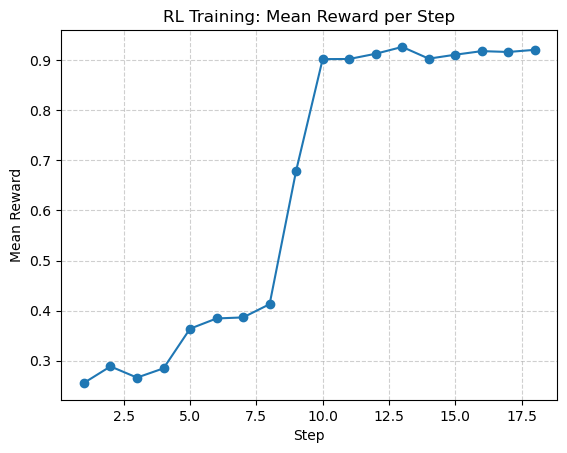

In [34]:
metrics_path = "logs/reverse_rl_grpo_run/metrics.jsonl"
df = pd.read_json(metrics_path, lines=True)

plt.figure()
plt.plot(df["step"], df["reward/mean"], marker="o", linestyle="-")
plt.xlabel("Step")
plt.ylabel("Mean Reward")
plt.title("RL Training: Mean Reward per Step")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [35]:
eval_finetuned_rl(
    "data/eval_reverse_rl.jsonl",
    "tinker://c4815cfd-2a3b-54a8-ad9b-a8424fd7cb40:train:0/sampler_weights/reverse-rl-grpo"  # paste the path from training
)

=== FINETUNED REVERSE RL RESULTS ===
Mean token-F1 vs target meaning: 0.5974

Saved finetuned reverse RL metrics to finetuned_reverse_rl_metrics.json


In [38]:
emb_model = SentenceTransformer("all-MiniLM-L6-v2")  # small, fast

def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8))

# Precompute target embeddings once (outside RL loop)
# targets = [ex["completion"] for ex in rl_examples]
# target_embs = emb_model.encode(targets, convert_to_numpy=True, normalize_embeddings=True)

def compute_reward_semantic(pred: str, target: str) -> float:
    """
    Smooth reward in [0,1] based on embedding cosine similarity.
    """
    embs = emb_model.encode([pred, target], convert_to_numpy=True, normalize_embeddings=True)
    sim = cosine_sim(embs[0], embs[1])
    # cosine is already ~[-1,1], but with normalized embeddings it's usually [0,1]
    # Just clip to [0,1] to be safe:
    return float(np.clip(sim, 0.0, 1.0))


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\golde\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\golde\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [40]:
def compute_hybrid_reward(pred: str, target: str) -> float:
    f1  = explanation_f1(pred, target)          # your existing token-F1
    sem = compute_reward_semantic(pred, target) # embedding cosine in [0,1]

    # combine them (weights are tunable)
    base = 0.4 * f1 + 0.6 * sem

    # (Optional) style penalties:
    #  - penalize using the slang word itself in the explanation
    #  - penalize overly long outputs
    pred_lower = pred.lower()
    target_len = len(target.split())
    pred_len   = len(pred.split())

    # you can build a slang set from slang_data.csv and pass it in
    penalty = 0.0
    # if any slang term appears in the explanation, subtract a bit
    # for slang in slang_set:
    #     if slang in pred_lower:
    #         penalty -= 0.05

    # length penalty: mild if much longer than target
    if pred_len > 2 * target_len:
        penalty -= 0.05

    reward = base + penalty
    return float(np.clip(reward, 0.0, 1.0))


In [39]:
# -------------- RL hyperparams (tweak as needed) --------------
BATCH_SIZE   = 64      # prompts per batch
GROUP_SIZE   = 4       # samples per prompt (GRPO-style groups)
LEARNING_RATE = 4e-5   # similar to Tinker rl_loop default :contentReference[oaicite:1]{index=1}
MAX_TOKENS   = 64      # max tokens for explanation
N_EPOCHS     = 2       # start small; this is online RL
SAVE_EVERY   = 50      # save sampler weights every N steps (optional)


# -------------- Load RL training examples --------------
# Re-use your existing loader: {"prompt": ..., "completion": ...}
rl_examples = load_finetune_examples(FINETUNE_PATH)
n_examples  = len(rl_examples)
n_batches   = n_examples // BATCH_SIZE
print(f"Loaded {n_examples} RL examples => {n_batches} batches of {BATCH_SIZE}.")


# -------------- Create training client starting from SFT --------------
service_client = tinker.ServiceClient()
training_client = service_client.create_training_client_from_state(resp_state.path)

tokenizer = training_client.get_tokenizer()

sampling_params = types.SamplingParams(
    max_tokens=MAX_TOKENS,
    temperature=0.7,
    top_p=0.9,
    stop=["\n"],
)

adam_params = types.AdamParams(
    learning_rate=LEARNING_RATE,
    beta1=0.9,
    beta2=0.95,
    eps=1e-8,
)

LOG_DIR = Path("logs/reverse_rl_grpo_semantic_run")
LOG_DIR.mkdir(parents=True, exist_ok=True)
metrics_path = LOG_DIR / "metrics.jsonl"

global_step = 0

for epoch in range(1, N_EPOCHS + 1):
    print(f"\n=== RL Epoch {epoch}/{N_EPOCHS} ===")

    # Shuffle examples each epoch
    idxs = np.arange(n_examples)
    np.random.shuffle(idxs)

    # Iterate over *all* examples, including the last partial batch
    for start in range(0, n_examples, BATCH_SIZE):
        t_start = time.time()
        global_step += 1

        end = min(start + BATCH_SIZE, n_examples)
        batch_idxs = idxs[start:end]
        batch_examples = [rl_examples[i] for i in batch_idxs]

        # We'll collect rollouts here
        batch_futures: List[List[Future[types.SampleResponse]]] = []
        batch_prompt_tokens: List[List[int]] = []
        batch_targets: List[str] = []

        # --------- 2) Create a sampler from current training weights ---------
        sampling_path = training_client.save_weights_for_sampler(
            name=f"rl_step_{global_step:06d}"
        ).result().path
        sampling_client = service_client.create_sampling_client(model_path=sampling_path)

        # --------- 3) Launch sampling (GROUP_SIZE per prompt) ---------
        for ex in batch_examples:
            prompt_text  = ex["prompt"]
            target_text  = ex["completion"]  # gold meaning for reward

            prompt_tokens = tokenizer.encode(prompt_text, add_special_tokens=True)
            model_input   = types.ModelInput.from_ints(tokens=prompt_tokens)

            sample_futures: List[Future[types.SampleResponse]] = []
            for _ in range(GROUP_SIZE):
                fut = sampling_client.sample(
                    prompt=model_input,
                    num_samples=1,
                    sampling_params=sampling_params,
                )
                sample_futures.append(fut)

            batch_futures.append(sample_futures)
            batch_prompt_tokens.append(prompt_tokens)
            batch_targets.append(target_text)

        # --------- 4) Gather samples, compute rewards, advantages ---------
        training_datums: List[types.Datum] = []
        batch_rewards: List[float] = []

        for sample_futures, prompt_tokens, target_text in zip(
            batch_futures, batch_prompt_tokens, batch_targets
        ):
            group_rewards: List[float] = []
            group_tokens: List[List[int]] = []
            group_logprobs: List[List[float]] = []
            group_ob_lens: List[int] = []

            for fut in sample_futures:
                sample_result = fut.result()
                seq = sample_result.sequences[0]
                sampled_tokens = seq.tokens
                sampled_logprobs = seq.logprobs
                assert sampled_logprobs is not None

                all_tokens = prompt_tokens + sampled_tokens

                # Observation length: all prompt tokens except the very first BOS
                ob_len = len(prompt_tokens) - 1

                # Decode only generated tokens for reward
                gen_text = tokenizer.decode(sampled_tokens)
                pred_text = parse_explanation(gen_text)

                reward = compute_reward_semantic(pred_text, target_text)

                group_tokens.append(all_tokens)
                group_logprobs.append(sampled_logprobs)
                group_ob_lens.append(ob_len)
                group_rewards.append(reward)

            # Group-relative baseline (GRPO-style)
            if len(group_rewards) == 0:
                continue

            group_mean = float(sum(group_rewards) / len(group_rewards))
            advantages = [r - group_mean for r in group_rewards]

            batch_rewards.append(group_mean)

            # If all advantages are 0, skip (no learning signal)
            if all(a == 0.0 for a in advantages):
                continue

            # --------- 5) Convert each sample in the group to a Datum ---------
            for tokens, logprob, advantage, ob_len in zip(
                group_tokens, group_logprobs, advantages, group_ob_lens
            ):
                # Standard LM shift
                input_tokens  = tokens[:-1]
                target_tokens = tokens[1:]

                # Sampling logprobs over whole prefix; 0s for prompt region,
                # then actual logprobs for generated region.
                all_logprobs = [0.0] * ob_len + list(logprob)
                if len(all_logprobs) < len(input_tokens):
                    all_logprobs += [0.0] * (len(input_tokens) - len(all_logprobs))
                all_logprobs = all_logprobs[: len(input_tokens)]

                # Advantages: 0 in prompt region, then constant advantage for generated region
                all_advantages = [0.0] * ob_len + [advantage] * (len(input_tokens) - ob_len)

                assert len(input_tokens) == len(target_tokens) == len(all_logprobs) == len(all_advantages), (
                    f"Length mismatch: "
                    f"input={len(input_tokens)}, target={len(target_tokens)}, "
                    f"logprobs={len(all_logprobs)}, adv={len(all_advantages)}"
                )

                datum = types.Datum(
                    model_input=types.ModelInput.from_ints(tokens=[int(t) for t in input_tokens]),
                    loss_fn_inputs={
                        "target_tokens": TensorData.from_torch(
                            torch.tensor(target_tokens, dtype=torch.long)
                        ),
                        "logprobs": TensorData.from_torch(
                            torch.tensor(all_logprobs, dtype=torch.float32)
                        ),
                        "advantages": TensorData.from_torch(
                            torch.tensor(all_advantages, dtype=torch.float32)
                        ),
                    },
                )
                training_datums.append(datum)

        # If no datums (e.g., all-zero rewards), just skip this step
        if not training_datums:
            print(f"step {global_step}: no RL datums (all-zero advantages), skipping.")
            continue

        # --------- 6) RL update with importance_sampling (policy gradient) ---------
        fwdbwd_res = training_client.forward_backward(
            training_datums, loss_fn="importance_sampling"
        )
        training_client.optim_step(adam_params)

        mean_reward = float(sum(batch_rewards) / len(batch_rewards)) if batch_rewards else 0.0
        elapsed = time.time() - t_start

        # Simple logging
        rec = {
            "step": global_step,
            "epoch": epoch,
            "time/total": elapsed,
            "reward/mean": mean_reward,
            "n_datums": len(training_datums),
        }
        with metrics_path.open("a", encoding="utf-8") as f:
            f.write(json.dumps(rec) + "\n")

        if global_step % 5 == 0:
            print(
                f"step {global_step} | epoch {epoch} | "
                f"mean_reward={mean_reward:.4f} | n_datums={len(training_datums)} | "
                f"time={elapsed:.2f}s"
            )

        # Optional: save sampler checkpoint every SAVE_EVERY steps
        if SAVE_EVERY > 0 and global_step % SAVE_EVERY == 0:
            ckpt = training_client.save_weights_for_sampler(
                name=f"rl_step_{global_step:06d}_ckpt"
            ).result().path
            print(f"Saved RL sampler weights at {ckpt}")

# Final save
final_path = training_client.save_weights_for_sampler(name="reverse-rl-grpo-semantic").result().path
print("Finished RL training; final sampler weights:", final_path)

Loaded 547 RL examples => 8 batches of 64.

=== RL Epoch 1/2 ===
step 5 | epoch 1 | mean_reward=0.7331 | n_datums=256 | time=15.21s

=== RL Epoch 2/2 ===
step 10 | epoch 2 | mean_reward=0.7515 | n_datums=256 | time=15.29s
step 15 | epoch 2 | mean_reward=0.7393 | n_datums=256 | time=16.10s
Finished RL training; final sampler weights: tinker://9530cc3d-c1a1-577b-895b-ce0eb3870a78:train:0/sampler_weights/reverse-rl-grpo-semantic


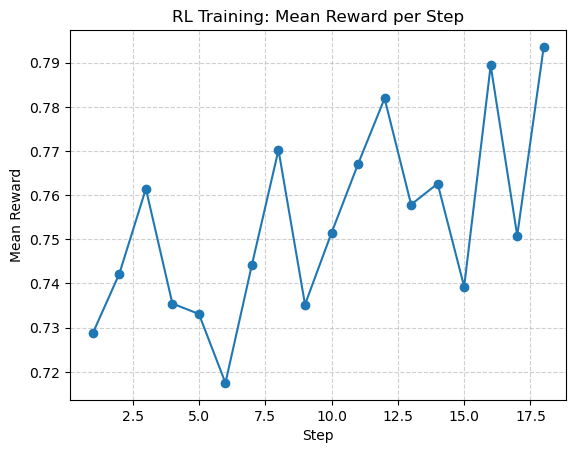

In [41]:
metrics_path = "logs/reverse_rl_grpo_semantic_run/metrics.jsonl"
df = pd.read_json(metrics_path, lines=True)

plt.figure()
plt.plot(df["step"], df["reward/mean"], marker="o", linestyle="-")
plt.xlabel("Step")
plt.ylabel("Mean Reward")
plt.title("RL Training: Mean Reward per Step")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [44]:
eval_finetuned_rl(
    'data/eval_reverse_rl.jsonl',
    'tinker://9530cc3d-c1a1-577b-895b-ce0eb3870a78:train:0/sampler_weights/reverse-rl-grpo-semantic'
)

=== FINETUNED REVERSE RL RESULTS ===
Mean token-F1 vs target meaning: 0.2013

Saved finetuned reverse RL metrics to finetuned_reverse_rl_metrics.json


In [42]:
# -------------- RL hyperparams (tweak as needed) --------------
BATCH_SIZE   = 64      # prompts per batch
GROUP_SIZE   = 4       # samples per prompt (GRPO-style groups)
LEARNING_RATE = 4e-5   # similar to Tinker rl_loop default :contentReference[oaicite:1]{index=1}
MAX_TOKENS   = 64      # max tokens for explanation
N_EPOCHS     = 2       # start small; this is online RL
SAVE_EVERY   = 50      # save sampler weights every N steps (optional)


# -------------- Load RL training examples --------------
# Re-use your existing loader: {"prompt": ..., "completion": ...}
rl_examples = load_finetune_examples(FINETUNE_PATH)
n_examples  = len(rl_examples)
n_batches   = n_examples // BATCH_SIZE
print(f"Loaded {n_examples} RL examples => {n_batches} batches of {BATCH_SIZE}.")


# -------------- Create training client starting from SFT --------------
service_client = tinker.ServiceClient()
training_client = service_client.create_training_client_from_state(resp_state.path)

tokenizer = training_client.get_tokenizer()

sampling_params = types.SamplingParams(
    max_tokens=MAX_TOKENS,
    temperature=0.7,
    top_p=0.9,
    stop=["\n"],
)

adam_params = types.AdamParams(
    learning_rate=LEARNING_RATE,
    beta1=0.9,
    beta2=0.95,
    eps=1e-8,
)

LOG_DIR = Path("logs/reverse_rl_grpo_hybrid_run")
LOG_DIR.mkdir(parents=True, exist_ok=True)
metrics_path = LOG_DIR / "metrics.jsonl"

global_step = 0

for epoch in range(1, N_EPOCHS + 1):
    print(f"\n=== RL Epoch {epoch}/{N_EPOCHS} ===")

    # Shuffle examples each epoch
    idxs = np.arange(n_examples)
    np.random.shuffle(idxs)

    # Iterate over *all* examples, including the last partial batch
    for start in range(0, n_examples, BATCH_SIZE):
        t_start = time.time()
        global_step += 1

        end = min(start + BATCH_SIZE, n_examples)
        batch_idxs = idxs[start:end]
        batch_examples = [rl_examples[i] for i in batch_idxs]

        # We'll collect rollouts here
        batch_futures: List[List[Future[types.SampleResponse]]] = []
        batch_prompt_tokens: List[List[int]] = []
        batch_targets: List[str] = []

        # --------- 2) Create a sampler from current training weights ---------
        sampling_path = training_client.save_weights_for_sampler(
            name=f"rl_step_{global_step:06d}"
        ).result().path
        sampling_client = service_client.create_sampling_client(model_path=sampling_path)

        # --------- 3) Launch sampling (GROUP_SIZE per prompt) ---------
        for ex in batch_examples:
            prompt_text  = ex["prompt"]
            target_text  = ex["completion"]  # gold meaning for reward

            prompt_tokens = tokenizer.encode(prompt_text, add_special_tokens=True)
            model_input   = types.ModelInput.from_ints(tokens=prompt_tokens)

            sample_futures: List[Future[types.SampleResponse]] = []
            for _ in range(GROUP_SIZE):
                fut = sampling_client.sample(
                    prompt=model_input,
                    num_samples=1,
                    sampling_params=sampling_params,
                )
                sample_futures.append(fut)

            batch_futures.append(sample_futures)
            batch_prompt_tokens.append(prompt_tokens)
            batch_targets.append(target_text)

        # --------- 4) Gather samples, compute rewards, advantages ---------
        training_datums: List[types.Datum] = []
        batch_rewards: List[float] = []

        for sample_futures, prompt_tokens, target_text in zip(
            batch_futures, batch_prompt_tokens, batch_targets
        ):
            group_rewards: List[float] = []
            group_tokens: List[List[int]] = []
            group_logprobs: List[List[float]] = []
            group_ob_lens: List[int] = []

            for fut in sample_futures:
                sample_result = fut.result()
                seq = sample_result.sequences[0]
                sampled_tokens = seq.tokens
                sampled_logprobs = seq.logprobs
                assert sampled_logprobs is not None

                all_tokens = prompt_tokens + sampled_tokens

                # Observation length: all prompt tokens except the very first BOS
                ob_len = len(prompt_tokens) - 1

                # Decode only generated tokens for reward
                gen_text = tokenizer.decode(sampled_tokens)
                pred_text = parse_explanation(gen_text)

                reward = compute_hybrid_reward(pred_text, target_text)

                group_tokens.append(all_tokens)
                group_logprobs.append(sampled_logprobs)
                group_ob_lens.append(ob_len)
                group_rewards.append(reward)

            # Group-relative baseline (GRPO-style)
            if len(group_rewards) == 0:
                continue

            group_mean = float(sum(group_rewards) / len(group_rewards))
            advantages = [r - group_mean for r in group_rewards]

            batch_rewards.append(group_mean)

            # If all advantages are 0, skip (no learning signal)
            if all(a == 0.0 for a in advantages):
                continue

            # --------- 5) Convert each sample in the group to a Datum ---------
            for tokens, logprob, advantage, ob_len in zip(
                group_tokens, group_logprobs, advantages, group_ob_lens
            ):
                # Standard LM shift
                input_tokens  = tokens[:-1]
                target_tokens = tokens[1:]

                # Sampling logprobs over whole prefix; 0s for prompt region,
                # then actual logprobs for generated region.
                all_logprobs = [0.0] * ob_len + list(logprob)
                if len(all_logprobs) < len(input_tokens):
                    all_logprobs += [0.0] * (len(input_tokens) - len(all_logprobs))
                all_logprobs = all_logprobs[: len(input_tokens)]

                # Advantages: 0 in prompt region, then constant advantage for generated region
                all_advantages = [0.0] * ob_len + [advantage] * (len(input_tokens) - ob_len)

                assert len(input_tokens) == len(target_tokens) == len(all_logprobs) == len(all_advantages), (
                    f"Length mismatch: "
                    f"input={len(input_tokens)}, target={len(target_tokens)}, "
                    f"logprobs={len(all_logprobs)}, adv={len(all_advantages)}"
                )

                datum = types.Datum(
                    model_input=types.ModelInput.from_ints(tokens=[int(t) for t in input_tokens]),
                    loss_fn_inputs={
                        "target_tokens": TensorData.from_torch(
                            torch.tensor(target_tokens, dtype=torch.long)
                        ),
                        "logprobs": TensorData.from_torch(
                            torch.tensor(all_logprobs, dtype=torch.float32)
                        ),
                        "advantages": TensorData.from_torch(
                            torch.tensor(all_advantages, dtype=torch.float32)
                        ),
                    },
                )
                training_datums.append(datum)

        # If no datums (e.g., all-zero rewards), just skip this step
        if not training_datums:
            print(f"step {global_step}: no RL datums (all-zero advantages), skipping.")
            continue

        # --------- 6) RL update with importance_sampling (policy gradient) ---------
        fwdbwd_res = training_client.forward_backward(
            training_datums, loss_fn="importance_sampling"
        )
        training_client.optim_step(adam_params)

        mean_reward = float(sum(batch_rewards) / len(batch_rewards)) if batch_rewards else 0.0
        elapsed = time.time() - t_start

        # Simple logging
        rec = {
            "step": global_step,
            "epoch": epoch,
            "time/total": elapsed,
            "reward/mean": mean_reward,
            "n_datums": len(training_datums),
        }
        with metrics_path.open("a", encoding="utf-8") as f:
            f.write(json.dumps(rec) + "\n")

        if global_step % 5 == 0:
            print(
                f"step {global_step} | epoch {epoch} | "
                f"mean_reward={mean_reward:.4f} | n_datums={len(training_datums)} | "
                f"time={elapsed:.2f}s"
            )

        # Optional: save sampler checkpoint every SAVE_EVERY steps
        if SAVE_EVERY > 0 and global_step % SAVE_EVERY == 0:
            ckpt = training_client.save_weights_for_sampler(
                name=f"rl_step_{global_step:06d}_ckpt"
            ).result().path
            print(f"Saved RL sampler weights at {ckpt}")

# Final save
final_path = training_client.save_weights_for_sampler(name="reverse-rl-grpo-hybrid").result().path
print("Finished RL training; final sampler weights:", final_path)

Loaded 547 RL examples => 8 batches of 64.

=== RL Epoch 1/2 ===
step 5 | epoch 1 | mean_reward=0.4990 | n_datums=256 | time=16.30s

=== RL Epoch 2/2 ===
step 10 | epoch 2 | mean_reward=0.5085 | n_datums=256 | time=17.01s
step 15 | epoch 2 | mean_reward=0.5386 | n_datums=256 | time=15.48s
Finished RL training; final sampler weights: tinker://f616af5a-85f4-5236-92c7-2bed03b46568:train:0/sampler_weights/reverse-rl-grpo-hybrid


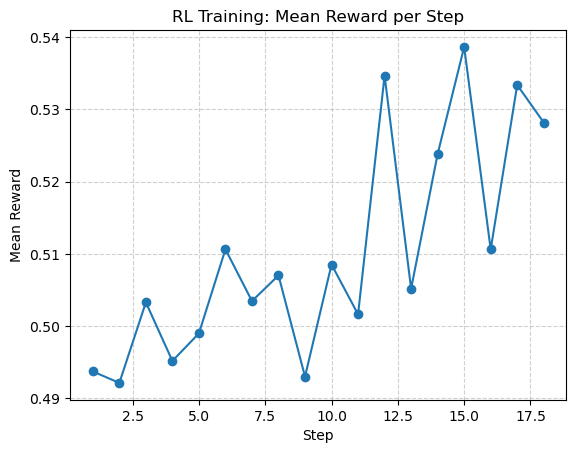

In [43]:
metrics_path = "logs/reverse_rl_grpo_hybrid_run/metrics.jsonl"
df = pd.read_json(metrics_path, lines=True)

plt.figure()
plt.plot(df["step"], df["reward/mean"], marker="o", linestyle="-")
plt.xlabel("Step")
plt.ylabel("Mean Reward")
plt.title("RL Training: Mean Reward per Step")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [ ]:
eval_finetuned_rl(
    'data/eval_reverse_rl.jsonl',
    'tinker://f616af5a-85f4-5236-92c7-2bed03b46568:train:0/sampler_weights/reverse-rl-grpo-hybrid'
)

=== FINETUNED REVERSE RL RESULTS ===
Mean token-F1 vs target meaning: 0.2071

Saved finetuned reverse RL metrics to finetuned_reverse_rl_metrics.json


In [50]:
def make_sampling_client(service_client, model_spec: Dict):
    """
    model_spec format:
      {
        "name": "baseline",
        "kind": "base",          # "base" or "sampler"
        "path": None             # for base, ignored
      }
      or:
      {
        "name": "sft",
        "kind": "sampler",
        "path": "tinker://.../sampler_weights/reverse-rl-sft"
      }
    """
    if model_spec["kind"] == "base":
        return service_client.create_sampling_client(base_model=BASE_MODEL)
    elif model_spec["kind"] == "sampler":
        return service_client.create_sampling_client(model_path=model_spec["path"])
    else:
        raise ValueError(f"Unknown model kind: {model_spec['kind']}")

In [51]:
def compare_models_on_examples(
    jsonl_path: str,
    model_specs: List[Dict],
    k: int = 5,
    max_tokens: int = 64,
):
    """
    Sample k examples from eval_reverse_rl.jsonl and print:
      - prompt (sentence + instructions)
      - gold target meaning
      - each model's generated explanation

    model_specs: list of dicts like:
        {"name": "baseline", "kind": "base",    "path": None}
        {"name": "sft",      "kind": "sampler", "path": "tinker://.../reverse-rl-sft"}
        {"name": "rl_f1",    "kind": "sampler", "path": "tinker://.../reverse-rl-grpo"}
        {"name": "rl_sem",   "kind": "sampler", "path": "tinker://.../reverse-rl-semantic"}
    """
    # 1) Load eval examples
    examples = load_eval_examples(jsonl_path)
    if not examples:
        print("No examples found in eval file:", jsonl_path)
        return

    # 2) Sample k examples (without replacement)
    k = min(k, len(examples))
    sampled = random.sample(examples, k)

    # 3) Create service client and tokenizer
    service_client = tinker.ServiceClient()
    tokenizer = get_tokenizer(BASE_MODEL)

    sampling_params = types.SamplingParams(
        max_tokens=max_tokens,
        temperature=0.0,   # deterministic to make comparison easier
        top_p=1.0,
        stop=["\n"],
    )

    # 4) Create a sampling client for each model spec
    model_clients = {}
    for spec in model_specs:
        client = make_sampling_client(service_client, spec)
        model_clients[spec["name"]] = client

    # 5) For each example, generate from each model and print
    for idx, ex in enumerate(sampled, 1):
        prompt = ex["prompt"]
        target = ex["target"]

        print("=" * 100)
        print(f"Example {idx}")
        print("-" * 100)
        print("Prompt (sentence + instructions):")
        print(prompt)
        print("\nGold meaning:")
        print(target)
        print()

        for model_name, client in model_clients.items():
            # Encode prompt
            tokens = tokenizer.encode(prompt, add_special_tokens=True)
            model_input = types.ModelInput.from_ints(tokens=tokens)

            # Sample
            result = client.sample(
                prompt=model_input,
                sampling_params=sampling_params,
                num_samples=1,
            ).result()

            gen_tokens = result.sequences[0].tokens
            gen_text   = tokenizer.decode(gen_tokens)
            pred_text  = parse_explanation(gen_text)

            print(f"[{model_name}]")
            print(pred_text)
            print()

        print()  # extra spacing between examples


In [53]:
model_specs = [
    {"name": "baseline", "kind": "base",    "path": None},
    {"name": "sft",      "kind": "sampler", "path": "tinker://e91e23ef-0595-5360-b4fa-b61a2231288c:train:0/sampler_weights/reverse_rl_sft"},
    {"name": "rl_f1",    "kind": "sampler", "path": "tinker://c4815cfd-2a3b-54a8-ad9b-a8424fd7cb40:train:0/sampler_weights/reverse-rl-grpo"},
    {"name": "rl_sem",   "kind": "sampler", "path": "tinker://9530cc3d-c1a1-577b-895b-ce0eb3870a78:train:0/sampler_weights/reverse-rl-grpo-semantic"},
    {"name": "rl_hyb",   "kind": "sampler", "path": "tinker://f616af5a-85f4-5236-92c7-2bed03b46568:train:0/sampler_weights/reverse-rl-grpo-hybrid"},
]

compare_models_on_examples(
    jsonl_path="data/eval_reverse_rl.jsonl",
    model_specs=model_specs,
    k=5,           # 5 examples
    max_tokens=64, # one short explanation
)


Example 1
----------------------------------------------------------------------------------------------------
Prompt (sentence + instructions):
You will be given a sentence that contains a modern slang term.
Explain what the sentence means in standard English, focusing on the slang.

Sentence: "I need to refill my rx this week."
Meaning:

Gold meaning:
A way of sending regards or best wishes, often used in email closings

[baseline]
The speaker is talking about prescription medication. "Rx" is an abbreviation for the Latin word "recipe," which stands for prescription. The speaker needs to obtain a refill on their prescription, probably because the medication needs to be reordered from their pharmacy.

[sft]
a way of sending regards or best wishes, often used in email closings. example: “thank you for your help”?  “no problem, take care”?  describe the tone of the conversation.  polite and appreciative.  what does take care typically signify?  a way to end a

[rl_f1]
a way of sending r